# Analysis of our data

1. Data collecting and data cleaning 
2. Computations for the creation of the adjacency matrix and the graph
3. Graph creation
4. Analysis

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas.io.json import json_normalize
import pickle
import re
import scipy as sp
from scipy import stats
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.options.mode.chained_assignment = None
import datetime
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import omdb

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zouag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zouag\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
%matplotlib inline

# 1. Data collecting and data cleaning

In [3]:
#import dataset
FILE_PATH_CREW = "../Data/tmdb_5000_credits.csv"

features_crew = pd.read_csv(FILE_PATH_CREW)

# Dataframe with info about the movies
features_crew.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [ ]:
#specify your API_KEY used to set client
API_y_KEY = '3a7e30ce'
omdb.set_default('apikey', API_y_KEY)
client = omdb.OMDBClient(apikey=API_y_KEY)

In [ ]:
#We have a 1000 request limit so you can decide here at which film you want to start and where to end 
id_end = 4803
id_start = id_end - 1000

In [ ]:
#creates empty dictionary then updates it using the movie_id as a key and the output of the
#request as value (note that that res.content isn't actually a dict but a byte object, we may
#need to convert it later)

collected = dict()

for i in range(id_start, id_end):
    title = features_crew.title[i]
    res = omdb.request(t=title, tomatoes=True)
    movie_json = res.content
    collected[str(features_crew.movie_id[i])] = movie_json

In [ ]:
# saves collected as pickle
with open('metacrit.p', 'wb') as fp:
    pickle.dump(collected, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
# loads collected
with open('metacrit.p', 'rb') as fp:
    test_data = pickle.load(fp)

# 2. Computations for the creation of the adjacency matrix and the graph

In [4]:
df = pd.DataFrame.from_dict(test_data, orient='index')
df.head()

,0
19995,"b'{""Title"":""Avatar"",""Year"":""2009"",""Rated"":""PG-..."
285,"b'{""Title"":""Pirates of the Caribbean: At World..."
206647,"b'{""Title"":""Spectre"",""Year"":""2015"",""Rated"":""PG..."
49026,"b'{""Title"":""The Dark Knight Rises"",""Year"":""201..."
49529,"b'{""Title"":""John Carter"",""Year"":""2012"",""Rated""..."


In [5]:
dataframe = pd.read_json(df.iloc[0].values[0])

for i in range(1, len(df)):
    if len(df.iloc[i].values[0]) > 100:
        movie = pd.read_json(df.iloc[i].values[0])
    dataframe = pd.concat([dataframe, movie])

In [6]:
# We decided to drop the useless columns that did not contain information about the movie
# These columns are: - urls (Poster, Website, tomatoImage)
#                    - columns related to the API (Response, Type)
#                    - columns where all entries are NaN
#                    - Irrelevant columns (DVD, ie release date of dvd)
#                    - Redundant columns (Year is redundant with Released)

dataframe = dataframe.drop(columns=['Poster', 'Response', 'Type', 'Website', 'tomatoConsensus', 
                                    'tomatoFresh', 'tomatoImage', 'tomatoMeter', 'tomatoRating', 
                                    'tomatoReviews', 'tomatoRotten', 'tomatoURL', 'tomatoUserMeter', 
                                    'tomatoUserRating', 'tomatoUserReviews', 'totalSeasons', 'DVD',
                                    'Year', 'Released'])
dataframe.head()

,Actors,Awards,BoxOffice,Country,Director,Genre,Language,Metascore,Plot,Production,Rated,Ratings,Runtime,Title,Writer,imdbID,imdbRating,imdbVotes
0,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000","UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",162 min,Avatar,James Cameron,tt0499549,7.8,"1,013,715"
1,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000","UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '82%'}",162 min,Avatar,James Cameron,tt0499549,7.8,"1,013,715"
2,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000","UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Metacritic', 'Value': '83/100'}",162 min,Avatar,James Cameron,tt0499549,7.8,"1,013,715"
0,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,"$309,404,152",USA,Gore Verbinski,"Action, Adventure, Fantasy",English,50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",169 min,Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",tt0449088,7.1,"542,125"
1,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,"$309,404,152",USA,Gore Verbinski,"Action, Adventure, Fantasy",English,50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '44%'}",169 min,Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",tt0449088,7.1,"542,125"


We now need to transform the types so that it is easier to analyze the features. As of now, almost all the entries of our dataframe are strings. We have a few entries that are integer numbers that need to be converted: BoxOffice, Metascore, Runtime and imdbVotes.

Metascore is already in an appropriate format, we just need to cast the type. However, BoxOffice, Runtime and imdbVotes need a little bit of tinkering.

In [7]:
# For Runtime we need to remove the ' min'
dataframe['Runtime'] = dataframe['Runtime'].apply(lambda x: x.replace(" min", ""))
dataframe['Runtime'] = dataframe['Runtime'].replace('N/A', np.nan)
dataframe['Runtime'] = dataframe['Runtime'].astype(float)
dataframe = dataframe.dropna()
dataframe['Runtime'] = dataframe['Runtime'].astype(int)
# For BoxOffice we need to remove the $ and commas
dataframe['BoxOffice'] = dataframe['BoxOffice'].apply(lambda x: x.replace("$", ""))
dataframe['BoxOffice'] = dataframe['BoxOffice'].apply(lambda x: x.replace(",", ""))
dataframe['BoxOffice'] = dataframe['BoxOffice'].replace('N/A', np.nan)
dataframe['BoxOffice'] = dataframe['BoxOffice'].astype(float)
dataframe = dataframe.dropna()
dataframe['BoxOffice'] = dataframe['BoxOffice'].astype(int)
# Metascore
dataframe['Metascore'] = dataframe['Metascore'].replace('N/A', np.nan)
dataframe = dataframe.dropna()
dataframe['Metascore'] = dataframe['Metascore'].astype(int)
# for imdbVotes we need to remove the commas
dataframe['imdbVotes'] = dataframe['imdbVotes'] .str.replace(',', '')
dataframe['imdbVotes'] = dataframe['imdbVotes'] .astype(float)
dataframe['imdbVotes'] = dataframe['imdbVotes'] .replace(np.nan, 0)

In [8]:
dataframe.head()

,Actors,Awards,BoxOffice,Country,Director,Genre,Language,Metascore,Plot,Production,Rated,Ratings,Runtime,Title,Writer,imdbID,imdbRating,imdbVotes
0,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,"UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",162,Avatar,James Cameron,tt0499549,7.8,1013715.0
1,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,"UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '82%'}",162,Avatar,James Cameron,tt0499549,7.8,1013715.0
2,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,"UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Metacritic', 'Value': '83/100'}",162,Avatar,James Cameron,tt0499549,7.8,1013715.0
0,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,309404152,USA,Gore Verbinski,"Action, Adventure, Fantasy",English,50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",169,Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",tt0449088,7.1,542125.0
1,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,309404152,USA,Gore Verbinski,"Action, Adventure, Fantasy",English,50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '44%'}",169,Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",tt0449088,7.1,542125.0


Now, we need to regroup the different sources of ratings so that the movies are not repeated three times in the dataframe.

- The first rating comes from imdb, its value is on a scale from 0 to 10
- The second rating comes from Rotten Tomatoes, its value is a percentage
- The third rating comes from Metacritic, its value is on a scale from 0 to 100

We wish to separate this column into 3 columns, drop the duplicate rows and convert the ratings to percentages for a more uniform notation.

In [9]:
dataframe_ = dataframe.copy()

In [10]:
def transform_tomatograde(strgrade):
    if '/10' in strgrade:
        grade = strgrade.replace('/10', '').replace('.', '')
    elif '%' in strgrade:
        grade = strgrade.replace('%', '')
    elif '/100' in dataframe_['metacriticGrade'][i]:
        grade = strgrade.replace('/100', '')
    else:
        grade = float(dataframe_['tomatoGrade'][i])
    grade = float(grade)
    if grade > 100:
        grade = grade / 10
    return int(grade)   

In [11]:
# 1. Extract the Rotten Tomatoes grade
dataframe_['RatingIndex'] = dataframe_.index
dataframe_ = dataframe_.reset_index(drop=True)
dataframe_['tomatoGrade'] = np.nan
for i in range(len(dataframe_[dataframe_.RatingIndex == 1])):
    title = dataframe_[dataframe_.RatingIndex == 1].iloc[i].Title
    idx = dataframe_[dataframe_.Title == title].index[0]
    grade = transform_tomatograde(dataframe_[dataframe_.RatingIndex == 1].iloc[i].Ratings['Value'])
    dataframe_.at[idx, 'tomatoGrade'] = grade
dataframe_ = dataframe_[dataframe_.RatingIndex == 0]
dataframe_ = dataframe_.drop(columns=['RatingIndex'])

# 2. Rename the Metacritics and imdb grades
dataframe_ = dataframe_.rename(columns={'imdbRating' : 'imdbGrade', 'Metascore' : 'metacriticGrade'})

# 3. Drop NaN
dataframe_ = dataframe_.dropna()

# 4. Transform grades
dataframe_['imdbGrade'] = dataframe_['imdbGrade']*10
dataframe_['imdbGrade'] = dataframe_['imdbGrade'].astype(int)
dataframe_['tomatoGrade'] = dataframe_['tomatoGrade'].astype(int)
dataframe_['metacriticGrade'] = dataframe_['metacriticGrade'].astype(int)

# 5. Reset index
dataframe_ = dataframe_.reset_index(drop=True)

# 6. Drop the Ratings column
dataframe_ = dataframe_.drop(columns=['Ratings'])

In [12]:
dataframe_.head()

,Actors,Awards,BoxOffice,Country,Director,Genre,Language,metacriticGrade,Plot,Production,Rated,Runtime,Title,Writer,imdbID,imdbGrade,imdbVotes,tomatoGrade
0,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,"UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,162,Avatar,James Cameron,tt0499549,78,1013715.0,82
1,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,309404152,USA,Gore Verbinski,"Action, Adventure, Fantasy",English,50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,169,Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",tt0449088,71,542125.0,44
2,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra...",Won 1 Oscar. Another 7 wins & 32 nominations.,208777731,"UK, USA",Sam Mendes,"Action, Adventure, Thriller","English, Spanish, Italian, German, French",60,A cryptic message from 007's past sends him pi...,Sony Pictures,PG-13,148,Spectre,"John Logan (screenplay by), Neal Purvis (scree...",tt2379713,68,343533.0,64
3,"Christian Bale, Gary Oldman, Tom Hardy, Joseph...",Nominated for 1 BAFTA Film Award. Another 38 w...,448130642,"UK, USA",Christopher Nolan,"Action, Thriller","English, Arabic",78,Eight years after the Joker's reign of anarchy...,Warner Bros. Pictures,PG-13,164,The Dark Knight Rises,"Jonathan Nolan (screenplay), Christopher Nolan...",tt1345836,84,1344474.0,87
4,"Taylor Kitsch, Lynn Collins, Samantha Morton, ...",2 wins & 8 nominations.,73058679,USA,Andrew Stanton,"Action, Adventure, Sci-Fi",English,51,"Transported to Barsoom, a Civil War vet discov...",Walt Disney Pictures,PG-13,132,John Carter,"Andrew Stanton (screenplay by), Mark Andrews (...",tt0401729,66,234717.0,51


Now, we need to deal with the string attributes that are in form of a list. We want a set of strings, each string corresponding to an individual characteristic (country, actor, etc).

In order to do so, we split the string at the commas. For the Writer attribute, we decided to remove the specifications and only keep the names of the writers, taking off who wrote the story, screenplay or characters.

In [13]:
dataframe_['Country'] = dataframe_['Country'].apply(lambda x: set(x.split(', ')))
dataframe_['Language'] = dataframe_['Language'].apply(lambda x: set(x.split(', ')))

In [14]:
dataframe_['Actors'] = dataframe_['Actors'].apply(lambda x: set(x.split(', ')))
dataframe_['Director'] = dataframe_['Director'].apply(lambda x: set(x.split(', ')))
dataframe_['Genre'] = dataframe_['Genre'].apply(lambda x: set(x.split(', ')))
dataframe_['Writer'] = dataframe_['Writer'].apply(lambda x: re.sub(" [\(\[].*?[\)\]]", "", x))
dataframe_['Writer'] = dataframe_['Writer'].apply(lambda x: set(x.split(', ')))

# comment on what am doing here

In [15]:
oscars_df = pd.read_csv('../Data/oscars.csv')
# Actor & actress (supporting or Leading role)
# Directing, Directing (Comedy Picture), Directing (Dramatic Picture)
# All the Writings

set(oscars_df.Award)
oscars_df.Year = oscars_df.Year.apply(lambda x: int(x[0:4]) if len(x) > 4 else int(x))
oscars_df= oscars_df[oscars_df.Year.apply(lambda x: x > 1930)].dropna()

In [16]:
oscars_df.head()

,Year,Ceremony,Award,Winner,Name,Film
159,1931,5,Actor,1.0,Wallace Beery,The Champ
161,1931,5,Actor,1.0,Fredric March,Dr. Jekyll and Mr. Hyde
164,1931,5,Actress,1.0,Helen Hayes,The Sin of Madelon Claudet
167,1931,5,Art Direction,1.0,Transatlantic,Gordon Wiles
170,1931,5,Cinematography,1.0,Shanghai Express,Lee Garmes


In [17]:
nominated_dir = oscars_df[oscars_df.Award.apply(lambda x: 'Directing' in x)][['Film']]
nominated_dir = nominated_dir.rename(columns={'Film' : 'Name'})

nominated_writ = oscars_df[oscars_df.Award.apply(lambda x: 'Writing' in x)][['Film']]
nominated_writ = nominated_writ.rename(columns={'Film' : 'Name'})

nominated_actors = oscars_df[oscars_df.Award.apply(lambda x: 'Actor' in x or 'Actress' in x)][['Name']]

awards = pd.concat([nominated_dir, nominated_writ, nominated_actors], axis = 0)

In [18]:
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace('Written by ', ''))
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace('Screenplay by ', ''))
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace('Written for the screen by ', ''))
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace('Story by', ''))
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace('(', ''))
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace(')', ''))
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace(' &', ','))
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace(';', ','))
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace(' and ', ', '))

In [19]:
awards.Name = awards.Name.apply(lambda x: x.replace('Written by ', ''))
awards.Name = awards.Name.apply(lambda x: x.replace('Screenplay by ', ''))
awards.Name = awards.Name.apply(lambda x: x.replace('Written for the screen by ', ''))
awards.Name = awards.Name.apply(lambda x: x.replace('Adaptation by ', ''))
awards.Name = awards.Name.apply(lambda x: x.replace('Dialogue by ', ''))
awards.Name = awards.Name.apply(lambda x: x.replace('Story by ', ''))
awards.Name = awards.Name.apply(lambda x: x.replace('Stories by ', ''))
awards.Name = awards.Name.apply(lambda x: x.replace('(', ''))
awards.Name = awards.Name.apply(lambda x: x.replace(')', ''))
awards.Name = awards.Name.apply(lambda x: x.replace(' &', ','))
awards.Name = awards.Name.apply(lambda x: x.replace(';', ','))
awards.Name = awards.Name.apply(lambda x: x.replace(' and ', ', '))
awards.Name = awards.Name.str.replace(', Jr.', ' Jr.')
awards.Name = awards.Name.str.replace('-', ' ')
awards.Name = awards.Name.str.strip()

In [20]:
award = pd.DataFrame(awards.Name.str.split(', ').tolist()).stack()
award = award.reset_index()[[0]]
award.columns = ['Names']

award = award.groupby('Names').agg({"Names": 'count'})
award.rename(columns={'Names': 'Awards'}, inplace=True)
award.reset_index(inplace=True)

award.head()

,Names,Awards
0,Aaron Sorkin,1
1,Abby Mann,1
2,Adam McKay,1
3,Adrien Brody,1
4,Akiva Goldsman,1


In [21]:
crew_act = dataframe_.loc[:,['Actors', 'Title']]
crew_dir = dataframe_.loc[:,['Director', 'Title']]
crew_writ = dataframe_.loc[:,['Writer', 'Title']]

crew_act.Actors = crew_act.Actors.apply(lambda x: ', '.join(list(x)))
crew_dir.Director = crew_dir.Director.apply(lambda x: ', '.join(list(x)))
crew_writ.Writer = crew_writ.Writer.apply(lambda x: ', '.join(list(x)))

crew_act = pd.DataFrame(crew_act.Actors.str.split(', ').tolist(), index=crew_act.Title).stack()
crew_act = crew_act.reset_index()[[0, 'Title']]
crew_act.columns = ['Actor', 'Title']

crew_dir = pd.DataFrame(crew_dir.Director.str.split(', ').tolist(), index=crew_dir.Title).stack()
crew_dir = crew_dir.reset_index()[[0, 'Title']]
crew_dir.columns = ['Director', 'Title']

crew_writ = pd.DataFrame(crew_writ.Writer.str.split(', ').tolist(), index=crew_writ.Title).stack()
crew_writ = crew_writ.reset_index()[[0, 'Title']]
crew_writ.columns = ['Writer', 'Title']

crew_writ.head()

,Writer,Title
0,James Cameron,Avatar
1,Terry Rossio,Pirates of the Caribbean: At World's End
2,Stuart Beattie,Pirates of the Caribbean: At World's End
3,Ted Elliott,Pirates of the Caribbean: At World's End
4,Jay Wolpert,Pirates of the Caribbean: At World's End


In [22]:
dataframe_tmp = dataframe_.loc[:,['Title', 'BoxOffice', 'Actors', 'Director', 'Writer']]
dataframe_tmp.columns = ['Title', 'BoxOffice', 'Actors', 'Directors', 'Writers']

crew_act = pd.merge(crew_act, dataframe_tmp, on='Title')[['Actor', 'BoxOffice']]
crew_act = crew_act.groupby('Actor').agg({"BoxOffice": 'sum'})
crew_act.rename(columns={'Actor': 'BoxOffice'}, inplace=True)
crew_act.reset_index(inplace=True)

crew_dir = pd.merge(crew_dir, dataframe_tmp, on='Title')[['Director', 'BoxOffice']]
crew_dir = crew_dir.groupby('Director').agg({"BoxOffice": 'sum'})
crew_dir.rename(columns={'Director': 'BoxOffice'}, inplace=True)
crew_dir.reset_index(inplace=True)

crew_writ = pd.merge(crew_writ, dataframe_tmp, on='Title')[['Writer', 'BoxOffice']]
crew_writ = crew_writ.groupby('Writer').agg({"BoxOffice": 'sum'})
crew_writ.rename(columns={'Writer': 'BoxOffice'}, inplace=True)
crew_writ.reset_index(inplace=True)

crew_writ.head()

,Writer,BoxOffice
0,A.A. Milne,44701110.0
1,A.E.W. Mason,18236897.0
2,A.J. Quinnell,77600000.0
3,Aaron Covington,81157671.0
4,Aaron Guzikowski,127452303.0


# end of what am doing

Now, we deal with the Production company. We have observed that a same company has different names within this dataset, sometimes the names diferring only by a space or an add-on (like "distribution"). We want to uniformize this.

In [23]:
to_remove = [' Corporation', ' Distribution', ' Corporat', ' Production', ' Films', ' Film', 
             ' Pictures', ' Picutres', ' Internationa', ' International', ' Industries', ' Compa', 
             ' Co', ' Distribu', ' Studios', ' Animation', ' Feature', ' SKG', ' LLC', ' Recommends', 
             ' Digital', ' Media', ' Video', ' Inc', ' Home Entertainment', ' Entertainment', ' Lorber', 
             ' Releasing', ' Cinema.', ' Cinema', ' Classics', ' Classic', ' Group', ' Europacorp', 
             ' Pvt. Ltd.', ' Ventures', ' [us]', ' Pictur', ' Home', ' Focus', ' City', ' Atomic', 
             ' Faith', ' Searchlight', ' Walden', '.', ' TriStarl', ' TriStar', ' Tristar']
for word in to_remove:
    dataframe_['Production'] = dataframe_['Production'].str.replace(word, '')

In [24]:
dataframe_['Production'] = dataframe_['Production'].str.replace('-', ' ')
dataframe_['Production'] = dataframe_['Production'].str.replace(' / ', '/')
dataframe_['Production'] = dataframe_['Production'].str.replace(' /', '/')
dataframe_['Production'] = dataframe_['Production'].str.replace('/ ', '/')
dataframe_['Production'] = dataframe_['Production'].str.replace('DreamWorks', 'Dreamworks')
dataframe_['Production'] = dataframe_['Production'].str.replace('Dream Works', 'Dreamworks')
dataframe_['Production'] = dataframe_['Production'].str.replace("Lion's Gate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace("Liongate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace("Lions Gate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace("LionsGate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace('Metro Goldwyn Mayer (MGM)', 'MGM')
dataframe_['Production'] = dataframe_['Production'].str.replace('Metro Goldwyn Mayer', 'MGM')
dataframe_['Production'] = dataframe_['Production'].str.replace('WARNER BROTHERS PICTURES', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('WB', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Weinsteinny', 'Weinstein')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warner Brothers', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warner Home', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warner Independent', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('PIXAR', 'Pixar')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warners Bros', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Universall', 'Universal')
dataframe_['Production'] = dataframe_['Production'].str.replace('The Weinstein', 'Weinstein')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Vantage', 'Weinstein')
dataframe_['Production'] = dataframe_['Production'].str.replace('/lumbia', '/ Columbia')
dataframe_['Production'] = dataframe_['Production'].str.replace('MGM (MGM)', 'MGM')
dataframe_['Production'] = dataframe_['Production'].str.replace(' First Take', '/ Columbia')
dataframe_['Production'] = dataframe_['Production'].str.replace('Goodbye Cruel', 'Goodbye Cruel World')
dataframe_['Production'] = dataframe_['Production'].str.replace('FoxFaith', 'Fox')
dataframe_['Production'] = dataframe_['Production'].str.replace('Fine Line', 'Fine Lines')
dataframe_['Production'] = dataframe_['Production'].str.replace('Erosl', 'Eros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Walt Disneys', 'Disney')
dataframe_['Production'] = dataframe_['Production'].str.replace('Walt Disney', 'Disney')

In [25]:
dataframe_['Production'] = dataframe_['Production'].apply(lambda x: set(x.split('/')))

Now, we deal with the plot. For this NLP task, we will keep it simple. We only kept the common nouns (singular or plural).

In [26]:
def find_nouns(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    nouns = [word for word,pos in tags if (pos == 'NN' or pos == 'NNS')]
    return set(nouns)

In [27]:
dataframe_['Plot'] = dataframe_['Plot'].apply(lambda x: find_nouns(x))

In [28]:
dataframe_

,Actors,Awards,BoxOffice,Country,Director,Genre,Language,metacriticGrade,Plot,Production,Rated,Runtime,Title,Writer,imdbID,imdbGrade,imdbVotes,tomatoGrade
0,"{Zoe Saldana, Stephen Lang, Sigourney Weaver, ...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,"{UK, USA}",{James Cameron},"{Sci-Fi, Fantasy, Action, Adventure}","{English, Spanish}",83,"{world, mission, marine, moon, home, orders}",{20th Century Fox},PG-13,162,Avatar,{James Cameron},tt0499549,78,1013715.0,82
1,"{Johnny Depp, Keira Knightley, Geoffrey Rush, ...",Nominated for 2 Oscars. Another 20 wins & 44 n...,309404152,{USA},{Gore Verbinski},"{Fantasy, Action, Adventure}",{English},50,"{alliances, edge, battle, map, treachery, betr...",{Buena Vista},PG-13,169,Pirates of the Caribbean: At World's End,"{Terry Rossio, Stuart Beattie, Ted Elliott, Ja...",tt0449088,71,542125.0,44
2,"{Léa Seydoux, Christoph Waltz, Daniel Craig, R...",Won 1 Oscar. Another 7 wins & 32 nominations.,208777731,"{UK, USA}",{Sam Mendes},"{Action, Thriller, Adventure}","{German, English, Spanish, Italian, French}",60,"{involvement, events, missions, learns, messag...",{Sony},PG-13,148,Spectre,"{Jez Butterworth, Neal Purvis, Ian Fleming, Ro...",tt2379713,68,343533.0,64
3,"{Tom Hardy, Joseph Gordon-Levitt, Christian Ba...",Nominated for 1 BAFTA Film Award. Another 38 w...,448130642,"{UK, USA}",{Christopher Nolan},"{Action, Thriller}","{Arabic, English}",78,"{reign, edge, help, years, guerrilla, exile, a...",{Warner Bros},PG-13,164,The Dark Knight Rises,"{David S. Goyer, Jonathan Nolan, Christopher N...",tt1345836,84,1344474.0,87
4,"{Taylor Kitsch, Lynn Collins, Samantha Morton,...",2 wins & 8 nominations.,73058679,{USA},{Andrew Stanton},"{Sci-Fi, Action, Adventure}",{English},51,"{creatures, princess, need, prisoner, savior, ...",{Disney},PG-13,132,John Carter,"{Andrew Stanton, Mark Andrews, Michael Chabon,...",tt0401729,66,234717.0,51
5,"{Tobey Maguire, Kirsten Dunst, Thomas Haden Ch...",Nominated for 1 BAFTA Film Award. Another 3 wi...,336530303,{USA},{Sam Raimi},"{Sci-Fi, Action, Adventure}","{French, English}",59,"{turmoil, bonds, world, villains, entity, reve...",{Sony},PG-13,139,Spider-Man 3,"{Stan Lee, Alvin Sargent, Steve Ditko, Ivan Ra...",tt0413300,62,445631.0,63
6,"{Donna Murphy, Mandy Moore, Ron Perlman, Zacha...",Nominated for 1 Oscar. Another 9 wins & 40 nom...,200803309,{USA},"{Byron Howard, Nathan Greno}","{Fantasy, Family, Comedy, Adventure, Romance, ...",{English},71,"{tower, world, thief, life, time}",{Disney},PG,100,Tangled,"{Wilhelm Grimm, Dan Fogelman, Jacob Grimm}",tt0398286,78,353478.0,89
7,"{Mark Ruffalo, Robert Downey Jr., Chris Evans,...",7 wins & 45 nominations.,429113729,{USA},{Joss Whedon},"{Sci-Fi, Action, Adventure}","{Korean, English}",66,"{heroes, peacekeeping, plan, program, things}",{Disney},PG-13,141,Avengers: Age of Ultron,"{Jack Kirby, Stan Lee, Joe Simon, Jim Starlin,...",tt2395427,74,619549.0,75
8,"{Michael Gambon, Dave Legeno, Daniel Radcliffe...",Nominated for 1 Oscar. Another 8 wins & 35 nom...,301920409,"{UK, USA}",{David Yates},"{Mystery, Fantasy, Family, Adventure}",{English},78,"{dark, past, year, property, book}",{Warner Bros},PG,153,Harry Potter and the Half-Blood Prince,"{J.K. Rowling, Steve Kloves}",tt0417741,76,397592.0,83
9,"{Henry Cavill, Jesse Eisenberg, Ben Affleck, A...",14 wins & 30 nominations.,293792936,{USA},{Zack Snyder},"{Sci-Fi, Fantasy, Action, Adventure}",{English},44,"{actions, kind, world, hero}",{Warner Bros},PG-13,151,Batman v Superman: Dawn of Justice,"{Bill Finger, David S. Goyer, Chris Terrio, Wi...",tt2975590,65,553233.0,27


We have found that among all movies, there are a lot of distinct words. For our machine learning analysis, this can be problematic because each word is one feature. 

In [ ]:
total_set = set()
for i in range(len(dataframe_)):
    total_set = total_set.union(dataframe_['Plot'][i])
    
len(total_set)

Indeed, there are 5734 words. We want to look at the distribution of the words.

In [ ]:
total_list = []
for i in range(len(dataframe_)):
    total_list = total_list + list(dataframe_['Plot'][i])

In [ ]:
from collections import Counter
word_counts = Counter(total_list)
word_df = pd.DataFrame.from_dict(word_counts, orient='index')

In [ ]:
df.plot(kind='hist', bins=100, figsize=(15, 10), logy=True, 
        title='Logarithm of histogram of the frequency of each plot word among all movies')
plt.show()

In [ ]:
df[df[0].apply(lambda x: x >= 100)]

The most common words among all the movies are the ones listed above. As we can see, most words do not describe the story (man, woman, life, school) but the scenario and the characters. We decided that the plot is useful for the graph creation but not for the machine learning analysis. 

We will use the plot for the graph creation (two similar movies will be movies that have a lot of plot words in common).

We need to format the Awards feature. The current Awards column contains a string (sentence) describing how many awards the movie has won or has been nominated to. It also specifies if it has won or been nominated to Oscars or BAFTA. We believe that when it is specified, the higher "award" is listed, i.e. if the movie won 2 Oscars, the 5 Oscar nominations won't be specified. The most useful format we could think of is to transform this award column into 2 distinct columns, since we cannot infer how many nominations to the Oscars a movie has when it has already won some. The columns are hence: 

- Wins
- Nominations

In [29]:
def find_wins_nominations(string):
    wins = 0
    noms = 0
    
    splitted = string.split('. ')
    if len(splitted) > 1:
        string1 = splitted[0]
        if re.search('nominated', string1, re.IGNORECASE):
            noms = noms + int(string1.split(' ')[2])
        if re.search('won', string1, re.IGNORECASE):
            wins = noms + int(string1.split(' ')[1])
        
        string2 = splitted[1]
        if re.search('nomination', string2, re.IGNORECASE):
            noms = noms + int(string2.split(' nomination')[0].split(' ')[-1])
        if re.search('win', string2, re.IGNORECASE):
            wins = wins + int(string2.split(' win')[0].split(' ')[-1])
    elif len(splitted) == 1:
        split_string = splitted[0]
        if re.search('nomination', split_string, re.IGNORECASE):
            noms = noms + int(split_string.split(' nomination')[0].split(' ')[-1])
        if re.search('win', split_string, re.IGNORECASE):
            wins = wins + int(split_string.split(' win')[0].split(' ')[-1])
    return wins, noms

In [30]:
dataframe_['Wins'] = 0
dataframe_['Nominations'] = 0

for i in range(0, len(dataframe_)):
    wins, noms = find_wins_nominations(dataframe_.Awards[i])
    dataframe_['Wins'][i] = wins
    dataframe_['Nominations'][i] = noms
dataframe_ = dataframe_.drop(columns='Awards')

The Rated attribute is not uniform and has multiple conventions. We seek to normalize it. We decided to use the Motion Picture Association of America film rating system, which states that:

- **G: General Audiences. All ages admitted.** Nothing that would offend parents for viewing by children.
- **PG: Parental Guidance Suggested.** Some material may not be suitable for children. Parents urged to give "parental guidance". May contain some material parents might not like for their young children.
- **PG-13: Parents Strongly Cautioned.** Some material may be inappropriate for children under 13. Parents are urged to be cautious. Some material may be inappropriate for pre-teenagers.
- **R: Restricted. Under 17 requires accompanying parent or adult guardian.** Contains some adult material. Parents are urged to learn more about the film before taking their young children with them.
- **NC-17: Adults Only.** No One 17 and Under Admitted. Clearly adult. Children are not admitted.

https://en.wikipedia.org/wiki/Motion_Picture_Association_of_America_film_rating_system

**X** rating means persons under 16 not admitted. For our analysis, we decided to conflate that label within **NC-17**

Following this, we need to make some modifications: 

- Approved -> G
- GP -> PG
- M -> R
- Passed -> G
- TV-14 -> PG-13
- TV-G -> G
- TV-MA -> R
- TV-PG -> PG
- X -> NC-17
- Unrated, Not rated and N/A make up their own category **Unrated**

In [31]:
dataframe_['Rated'] = dataframe_['Rated'].str.replace('APPROVED', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('GP', 'PG')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('M', 'R')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('PASSED', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-14', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('APPROVED', 'PG-13')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-G', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-MA', 'R')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-PG', 'PG')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('X', 'NC-17')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('NOT RATED', 'UNRATED')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('N/A', 'UNRATED')

In [32]:
dataframe_['Rated'] = dataframe_['Rated'].apply(lambda x: {x})

In order to make it easier to analyze, we decided to transform every foreign language into the label "Foreign" except from Spanish.

In [33]:
def format_languages(lang_set):
    if (lang_set - {'English', 'Spanish'}) != set(): # There are other things than English 
        if 'English' not in lang_set: # There is only other things than English
            if 'Spanish' not in lang_set:
                new_label = {'Other'}
            else: 
                new_label = {'Spanish', 'Other'}
        else:
            if 'Spanish' not in lang_set:
                new_label = {'English', 'Foreign'}
            else:
                new_label = {'English', 'Spanish', 'Other'}
    else:
        if 'English' not in lang_set:
            if 'Spanish' not in lang_set:
                new_label = set()
            else: 
                new_label = {'Spanish'}
        else:
            if 'Spanish' not in lang_set:
                new_label = {'English'}
            else:
                new_label = {'English', 'Spanish'}
    return new_label

In [34]:
dataframe_['Language'] = dataframe_['Language'].apply(lambda x: format_languages(x))

The countries are formatted so as to show 'USA' or 'Foreign'.

In [35]:
def format_country(country_set):
    if (country_set - {'USA'}) != set():
        if 'USA' not in country_set:
            new_label = {'Foreign'}
        else:
            new_label = {'USA', 'Foreign'}
    else:
        if 'USA' not in country_set:
            new_label = set()
        else:
            new_label = {'USA'}
    return new_label

In [36]:
dataframe_['Country'] = dataframe_['Country'].apply(lambda x: format_country(x))

In [37]:
dataframe_.to_pickle("df.pkl")

In [38]:
dataframe_ = pd.read_pickle("df.pkl")

Finally, we need to add the budget. For that, we use the budget column in the Kaggle imdb dataset.

In [39]:
FILE_PATH_MOVIE = "../Data/tmdb_5000_movies.csv"
movie_df = pd.read_csv(FILE_PATH_MOVIE)

budget_df = movie_df[['budget', 'title']]
budget_df = budget_df.rename(columns={"budget" : "Budget", "title" : "Title"})

final_df = dataframe_.merge(budget_df, how='inner')

In [40]:
# Budget is weirdly formatted: there are movies that state a single number budget to signify its millions.
# Let's unify it

final_df['Budget'].iloc[1971] = final_df['Budget'].iloc[1971] * 10**6
final_df['Budget'].iloc[1608] = final_df['Budget'].iloc[1608] * 10**6
final_df['Budget'].iloc[2330] = final_df['Budget'].iloc[2330] * 10**6
final_df['Budget'].iloc[1861] = 5500000
final_df['Budget'].iloc[2310] = 650000
final_df['Budget'].iloc[764] = 45000000
final_df['Budget'].iloc[2349] = 153000

# Moreover, we have budgets that are 0. We will replace these as np.nan then drop the whole row
final_df['Budget'] = final_df['Budget'].apply(lambda x: np.nan if x==0 else x)

In [128]:
final_df = final_df.dropna()
final_df.reset_index(inplace=True)

In [42]:
final_df = final_df.drop(columns=['imdbID'])

In [43]:
final_df.to_pickle("final_df.pkl")

In [44]:
dataframe_tmp = final_df.loc[:,['Actors','Director','Writer']]

In [45]:
dataframe_tmp

,Actors,Director,Writer
0,"{Zoe Saldana, Stephen Lang, Sigourney Weaver, ...",{James Cameron},{James Cameron}
1,"{Johnny Depp, Keira Knightley, Geoffrey Rush, ...",{Gore Verbinski},"{Terry Rossio, Stuart Beattie, Ted Elliott, Ja..."
2,"{Léa Seydoux, Christoph Waltz, Daniel Craig, R...",{Sam Mendes},"{Jez Butterworth, Neal Purvis, Ian Fleming, Ro..."
3,"{Tom Hardy, Joseph Gordon-Levitt, Christian Ba...",{Christopher Nolan},"{Jonathan Nolan, David S. Goyer, Christopher N..."
4,"{Taylor Kitsch, Lynn Collins, Samantha Morton,...",{Andrew Stanton},"{Andrew Stanton, Mark Andrews, Michael Chabon,..."
5,"{Tobey Maguire, Kirsten Dunst, Thomas Haden Ch...",{Sam Raimi},"{Stan Lee, Alvin Sargent, Steve Ditko, Ivan Ra..."
6,"{Donna Murphy, Mandy Moore, Ron Perlman, Zacha...","{Byron Howard, Nathan Greno}","{Wilhelm Grimm, Dan Fogelman, Jacob Grimm}"
7,"{Robert Downey Jr., Mark Ruffalo, Chris Evans,...",{Joss Whedon},"{Jack Kirby, Stan Lee, Joe Simon, Jim Starlin,..."
8,"{Daniel Radcliffe, Dave Legeno, Michael Gambon...",{David Yates},"{J.K. Rowling, Steve Kloves}"
9,"{Henry Cavill, Jesse Eisenberg, Amy Adams, Ben...",{Zack Snyder},"{Bill Finger, David S. Goyer, William Moulton ..."


In [129]:
crew_awards = pd.DataFrame(set(), index=np.arange(len(dataframe_tmp)), columns=['Names'])

for i in range(len(dataframe_tmp)):
    loc_list = list(dataframe_tmp.iloc[i])
    crew_awards.iloc[i].Names = loc_list[0]|loc_list[1]|loc_list[2]
crew_awards['Awards'] = 0

In [130]:
rev_act = final_df[['Actors']].copy()
rev_act['BoxOffice_actors'] = 0

rev_dir = final_df[['Director']].copy()
rev_dir['BoxOffice_directors'] = 0

rev_writ = final_df[['Writer']].copy()
rev_writ['BoxOffice_writers'] = 0

In [131]:
for (s,set_) in enumerate(crew_awards.Names):
    for item_ in set_:
        if not award[award['Names']==item_].Awards.empty:
            crew_awards.at[s, 'Awards'] = crew_awards.at[s, 'Awards'] + award[award['Names']==item_].Awards      
        

In [133]:
for (s,set_) in enumerate(rev_act.Actors):
    for item_ in set_:
        rev_act.at[s, 'BoxOffice_actors'] = rev_act.at[s, 'BoxOffice_actors'].copy() + crew_act[crew_act['Actor']==item_].BoxOffice.copy()
        
for (s,set_) in enumerate(rev_dir.Director):
    for item_ in set_:
        rev_dir.at[s, 'BoxOffice_directors'] = rev_dir.at[s, 'BoxOffice_directors'].copy() + crew_dir[crew_dir['Director']==item_].BoxOffice.copy()     

for (s,set_) in enumerate(rev_writ.Writer):
    for item_ in set_:
        rev_writ.at[s, 'BoxOffice_writers'] = rev_writ.at[s, 'BoxOffice_writers'].copy() + crew_writ[crew_writ['Writer']==item_].BoxOffice.copy()      
  

In [134]:
final_df['Awards'] = crew_awards.Awards
final_df['BoxOffice_actors'] = rev_act.BoxOffice_actors
final_df['BoxOffice_directors'] = rev_dir.BoxOffice_directors
final_df['BoxOffice_writers'] = rev_writ.BoxOffice_writers

final_df.to_pickle("final_df.pkl")
final_df.head()

,index,Actors,BoxOffice,Country,Director,Genre,Language,metacriticGrade,Plot,Production,...,imdbGrade,imdbVotes,tomatoGrade,Wins,Nominations,Budget,Awards,BoxOffice_actors,BoxOffice_directors,BoxOffice_writers
0,0,"{Zoe Saldana, Stephen Lang, Sigourney Weaver, ...",749700000,"{Foreign, USA}",{James Cameron},"{Sci-Fi, Fantasy, Action, Adventure}","{English, Spanish}",83,"{world, mission, marine, moon, home, orders}",{20th Century Fox},...,78,1013715.0,82,88,128,237000000.0,1,8749225092,947816802,1173684544
1,1,"{Johnny Depp, Keira Knightley, Geoffrey Rush, ...",309404152,{USA},{Gore Verbinski},"{Fantasy, Action, Adventure}",{English},50,"{alliances, edge, battle, map, treachery, betr...",{Buena Vista},...,71,542125.0,44,20,46,300000000.0,1,11629042234,1329316576,6439780219
2,2,"{Léa Seydoux, Christoph Waltz, Daniel Craig, R...",208777731,"{Foreign, USA}",{Sam Mendes},"{Action, Thriller, Adventure}","{English, Spanish, Other}",60,"{involvement, events, missions, learns, messag...",{Sony},...,68,343533.0,64,8,32,245000000.0,3,6479178314,706988158,4338225868
3,3,"{Tom Hardy, Joseph Gordon-Levitt, Christian Ba...",448130642,"{Foreign, USA}",{Christopher Nolan},"{Action, Thriller}","{Foreign, English}",78,"{reign, edge, help, annihilation, years, guerr...",{Warner Bros},...,84,1344474.0,87,38,103,250000000.0,1,10153049812,1781097215,6820715653
4,4,"{Taylor Kitsch, Lynn Collins, Samantha Morton,...",73058679,{USA},{Andrew Stanton},"{Sci-Fi, Action, Adventure}",{English},51,"{creatures, princess, need, prisoner, savior, ...",{Disney},...,66,234717.0,51,2,8,260000000.0,0,2713356406,677337921,2082778011


### Data cleaning results

We get a dataframe with the following features:

- Actors, Director, Writer
- Genre
- Budget
- Production
- Plot
- Country, Language
- Release date
- Runtime
- Rated category (PG-13, 18...)

Each movie has one identifyier:

- Title

And we have several labels that define the success of the movie:

- Box Office
- imdb Grade (+ imdb votes)
- Rotten Tomatoes Grade
- Metacritic Grade
- Wins and Nominations

# 3. ML

In [84]:
final_df = pd.read_pickle("final_df.pkl")

In [91]:
final_df.dtypes

index                    int64
Actors                  object
BoxOffice                int32
Country                 object
Director                object
Genre                   object
Language                object
metacriticGrade          int32
Plot                    object
Production              object
Rated                   object
Runtime                  int32
Title                   object
Writer                  object
imdbGrade                int32
imdbVotes              float64
tomatoGrade              int32
Wins                     int64
Nominations              int64
Budget                 float64
Awards                   int64
BoxOffice_actors         int64
BoxOffice_directors      int64
BoxOffice_writers        int64
dtype: object

In [540]:
ml_df = final_df.drop(columns=['index','Actors','Director','Plot','Production','Title','Writer','Awards','imdbVotes'])

In [541]:
ml_df.dtypes

BoxOffice                int32
Country                 object
Genre                   object
Language                object
metacriticGrade          int32
Rated                   object
Runtime                  int32
imdbGrade                int32
tomatoGrade              int32
Wins                     int64
Nominations              int64
Budget                 float64
BoxOffice_actors         int64
BoxOffice_directors      int64
BoxOffice_writers        int64
dtype: object

In [542]:
numerical_ml_df = ml_df[ml_df.select_dtypes(include=['int32','int64','float64']).columns]

In [543]:
ml_df['Language'] = ml_df['Language'].apply(lambda x: ','.join(list(x)))
ml_df['Country']  = ml_df['Country'].apply(lambda x: ','.join(list(x)))
ml_df['Genre']    = ml_df['Genre'].apply(lambda x: ','.join(list(x)))
ml_df['Rated']    = ml_df['Rated'].apply(lambda x: ','.join(list(x)))

In [544]:
from sklearn.feature_extraction.text import CountVectorizer

def getCatFeatures(df, Col):
    vectorizer = CountVectorizer(binary=True,
                                 ngram_range=(1,1),
                                 tokenizer=lambda x:[a.strip() for a in x.split(',')])
    return (vectorizer.fit_transform(df[Col]), vectorizer.vocabulary_)

In [545]:
Country_df, Country_voc = getCatFeatures(ml_df, 'Country')
Country_voc = sorted(list(Country_voc.keys()))

Genre_df, Genre_voc = getCatFeatures(ml_df, 'Genre')
Genre_voc = sorted(list(Genre_voc.keys()))

Lang_df, Lang_voc = getCatFeatures(ml_df, 'Language')
Lang_voc = sorted(list(Lang_voc.keys()))

Rated_df, Rated_voc = getCatFeatures(ml_df, 'Rated')
Rated_voc = sorted(list(Rated_voc.keys()))

In [546]:
SM = sprs.hstack([Country_df, Genre_df, Lang_df, Rated_df],'csr')
cat_ml_df = pd.SparseDataFrame([pd.SparseSeries(SM[i].toarray().ravel()) for i in np.arange(SM.shape[0])],
                               columns = Country_voc+Genre_voc+Lang_voc+Rated_voc)

In [547]:
final_ml_df = pd.concat([numerical_ml_df,cat_ml_df],axis=1)

In [548]:
target_ml   = final_ml_df[['BoxOffice', 'imdbGrade', 'tomatoGrade', 'metacriticGrade','Nominations','Wins']]
features_ml = final_ml_df.drop(columns=['BoxOffice', 'imdbGrade', 'tomatoGrade', 'metacriticGrade','Nominations','Wins'])

In [549]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_ml, target_ml, test_size=0.2, random_state=1, shuffle=True)

In [550]:
def plot_validation_curve(train_scores,cv_scores,x_data,scale='lin',title='',y_label='',x_label=''):

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    lw = 2

    plt.fill_between(x_data, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.2, color="r", lw=lw)
    plt.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="g", lw=lw)

    if (scale == 'lin'):
        plt.plot(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
    elif (scale == 'log'):
        plt.semilogx(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.semilogx(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

In [551]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

lasso_pipeline = make_pipeline(StandardScaler(), Lasso())
cv_schema = StratifiedKFold(n_splits = 5, random_state = 1)
MSE = make_scorer(mean_squared_error)

## IMdB grade as target 

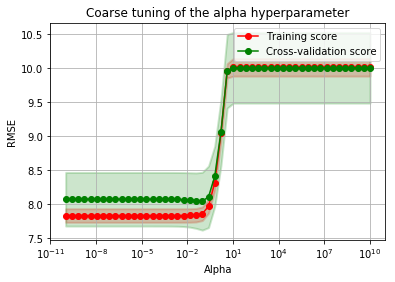

In [630]:
alpha_range = np.logspace(-10, 10, 50)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['imdbGrade'], param_name="lasso__alpha",
                                                       param_range=alpha_range, cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range,
                      'log', 'Coarse tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

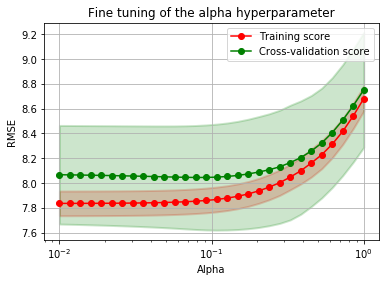

In [631]:
alpha_range_fine = np.logspace(-2, 0, 30)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['imdbGrade'], param_name="lasso__alpha",
                                                       param_range=alpha_range_fine, cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range_fine,
                      'log', 'Fine tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

In [632]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
lasso_pipeline.set_params(lasso__alpha = optimal_alpha_l)

lasso_pipeline.fit(X_train,y_train['imdbGrade'])
lasso_predict = lasso_pipeline.predict(X_test)

lasso_regr_imdb = np.abs(lasso_pipeline.named_steps['lasso'].coef_.copy())
print(lasso_regr_imdb)

[2.86944866e+00 1.40557367e+00 1.23186982e+00 1.32389856e+00
 8.28974917e-01 7.18555277e-01 5.02373520e-01 6.43551353e-01
 0.00000000e+00 1.82319477e+00 5.05504513e-01 1.36096059e+00
 0.00000000e+00 9.84415043e-01 1.87884845e+00 0.00000000e+00
 2.76334382e-01 3.28999735e-01 1.05134840e+00 3.93582973e-01
 1.52132836e-01 0.00000000e+00 0.00000000e+00 4.44066552e-01
 2.11868466e-01 1.78730717e-03 4.10755481e-01 2.25353413e-01
 2.54462182e-01 9.65872275e-01 2.81587688e-02 0.00000000e+00
 0.00000000e+00 2.74269788e-02 1.97738670e-02 0.00000000e+00
 2.54871138e-01 1.12848149e+00 1.70496448e-01]


In [705]:
feature_zero_IMdB = X_train.columns[np.where(lasso_regr_imdb == 0)[0]]
set_non_zero_features_IMdB = set(X_train.columns[np.where(lasso_regr_imdb != 0)[0]])

# The feature list is ordeed by importance then we keep only the 10 most important features
feature_IMdB = X_train.columns[np.argsort(lasso_regr_imdb)][::-1][:10]

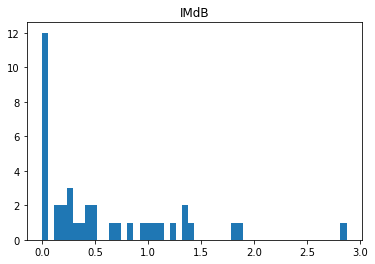

In [634]:
plt.figure(1)
plt.hist(np.abs(lasso_regr_imdb),bins=50)
plt.title('IMdB')
plt.show()

## Rotten Tomatoes grade as target

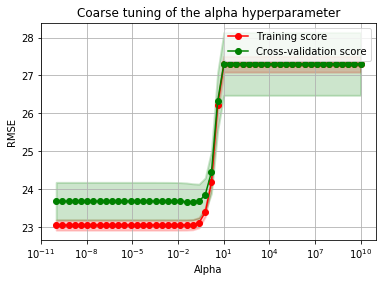

In [635]:
alpha_range = np.logspace(-10, 10, 50)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['tomatoGrade'],
                                                       param_name="lasso__alpha",param_range=alpha_range,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range,
                      'log', 'Coarse tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

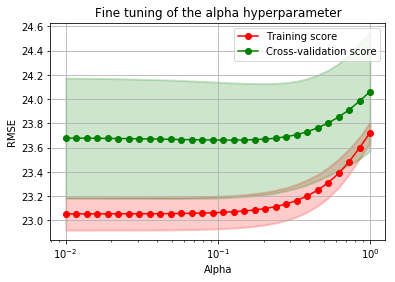

In [636]:
alpha_range_fine = np.logspace(-2, 0, 30)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['tomatoGrade'],
                                                       param_name="lasso__alpha",param_range=alpha_range_fine,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range_fine,
                      'log', 'Fine tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

In [637]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
lasso_pipeline.set_params(lasso__alpha = optimal_alpha_l)

lasso_pipeline.fit(X_train,y_train['tomatoGrade'])
lasso_predict = lasso_pipeline.predict(X_test)

lasso_regr_RT = np.abs(lasso_pipeline.named_steps['lasso'].coef_.copy())
print(lasso_regr_RT)

[4.70460125e+00 4.53021055e+00 2.83045019e+00 3.28331000e+00
 3.48441466e+00 1.89577142e+00 2.53592394e+00 2.19744986e+00
 1.22952192e+00 3.75241689e+00 1.27732635e+00 1.27740089e+00
 5.38761187e-01 3.81271332e+00 5.66189950e+00 1.47314962e+00
 8.78610727e-01 9.00637409e-01 1.21014259e+00 2.94564052e-01
 1.22922082e+00 7.54637901e-01 8.64396773e-02 2.08639646e+00
 1.14211146e+00 3.30538920e-03 1.41592242e+00 1.09489033e+00
 6.25084284e-01 2.18747771e+00 2.69901080e-01 0.00000000e+00
 0.00000000e+00 5.68171453e-01 4.23851125e-01 0.00000000e+00
 1.27434311e+00 3.49413941e+00 0.00000000e+00]


In [704]:
feature_zero_RT = X_train.columns[np.where(lasso_regr_RT == 0)[0]]
set_non_zero_features_RT = set(X_train.columns[np.where(lasso_regr_RT != 0)[0]])

# The feature list is ordeed by importance then we keep only the 10 most important features
feature_RT = X_train.columns[np.argsort(lasso_regr_RT)][::-1][:10]

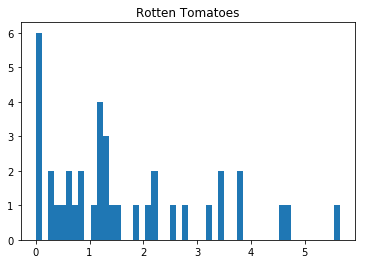

In [639]:
plt.figure(2)
plt.hist(np.abs(lasso_regr_RT),bins=50)
plt.title('Rotten Tomatoes')
plt.show()

## Metacritic grade as target

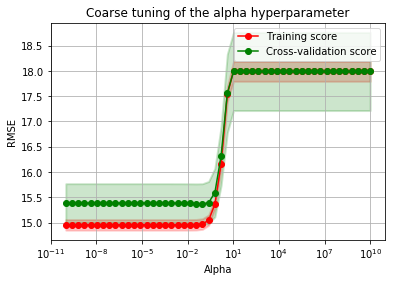

In [664]:
alpha_range = np.logspace(-10, 10, 50)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['metacriticGrade'],
                                                       param_name="lasso__alpha",param_range=alpha_range,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range,
                      'log', 'Coarse tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

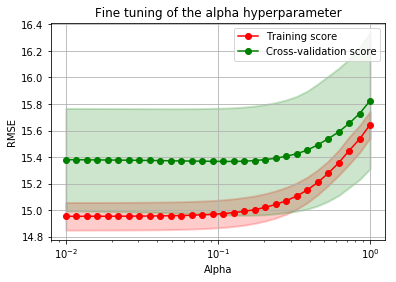

In [665]:
alpha_range_fine = np.logspace(-2, 0, 30) 

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['metacriticGrade'],
                                                       param_name="lasso__alpha",param_range=alpha_range_fine,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range_fine,
                      'log', 'Fine tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

In [666]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
lasso_pipeline.set_params(lasso__alpha = optimal_alpha_l)

lasso_pipeline.fit(X_train,y_train['tomatoGrade'])
lasso_predict = lasso_pipeline.predict(X_test)

lasso_regr_MC = np.abs(lasso_pipeline.named_steps['lasso'].coef_.copy())
print(lasso_regr_MC)

[4.70460125e+00 4.53021055e+00 2.83045019e+00 3.28331000e+00
 3.48441466e+00 1.89577142e+00 2.53592394e+00 2.19744986e+00
 1.22952192e+00 3.75241689e+00 1.27732635e+00 1.27740089e+00
 5.38761187e-01 3.81271332e+00 5.66189950e+00 1.47314962e+00
 8.78610727e-01 9.00637409e-01 1.21014259e+00 2.94564052e-01
 1.22922082e+00 7.54637901e-01 8.64396773e-02 2.08639646e+00
 1.14211146e+00 3.30538920e-03 1.41592242e+00 1.09489033e+00
 6.25084284e-01 2.18747771e+00 2.69901080e-01 0.00000000e+00
 0.00000000e+00 5.68171453e-01 4.23851125e-01 0.00000000e+00
 1.27434311e+00 3.49413941e+00 0.00000000e+00]


In [703]:
feature_zero_MC = X_train.columns[np.where(lasso_regr_MC == 0)[0]]
set_non_zero_features_MC = set(X_train.columns[np.where(lasso_regr_MC != 0)[0]])

# The feature list is ordeed by importance then we keep only the 10 most important features
feature_MC = X_train.columns[np.argsort(lasso_regr_MC)][::-1][:10]

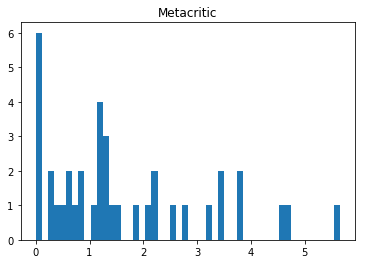

In [668]:
plt.hist(np.abs(lasso_regr_MC),bins=50)
plt.title('Metacritic')
plt.show()

## BoxOffice as target

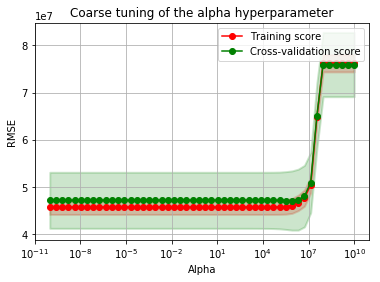

In [645]:
alpha_range = np.logspace(-10, 10, 50)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['BoxOffice'],
                                                       param_name="lasso__alpha",param_range=alpha_range,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range,
                      'log', 'Coarse tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

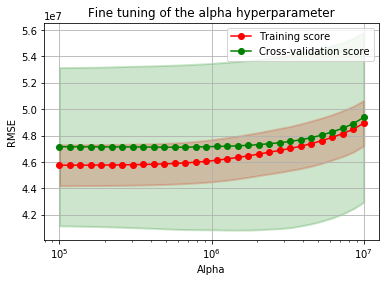

In [646]:
alpha_range_fine = np.logspace(5, 7, 30) 

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['BoxOffice'],
                                                       param_name="lasso__alpha",param_range=alpha_range_fine,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range_fine,
                      'log', 'Fine tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

In [647]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
lasso_pipeline.set_params(lasso__alpha = optimal_alpha_l)

lasso_pipeline.fit(X_train,y_train['BoxOffice'])
lasso_predict = lasso_pipeline.predict(X_test)

lasso_regr_BO = np.abs(lasso_pipeline.named_steps['lasso'].coef_.copy())
print(lasso_regr_BO)

[ 4458110.12524251 20715626.88770532 18060945.92133983 13109143.33387049
 17094387.65171273  1814081.10886448  2267623.31018552   766614.53841136
        0.          2440517.10329678        0.            49261.04022221
  2329160.72134166   346864.67102039  2465825.10890304   488295.94602647
   788422.85038104  1382209.66141011  1909428.59888218   986128.88974396
   262381.6565231    269058.50687916        0.                0.
        0.           535305.45146612   806441.90730935  1482268.13275263
  3341582.73229174  2116678.71035826   376433.22603001  1834159.55589728
  2546913.55359076  1626226.46978373        0.          3022319.40372958
        0.          2163741.88344606        0.        ]


In [648]:
feature_zero_BO = X_train.columns[np.where(lasso_regr_BO == 0)[0]]
set_non_zero_features_BO = set(X_train.columns[np.where(lasso_regr_BO != 0)[0]])

# The feature list is ordeed by importance then we keep only the 10 most important features
feature_BO = X_train.columns[np.argsort(lasso_regr_BO)][::-1][:10]

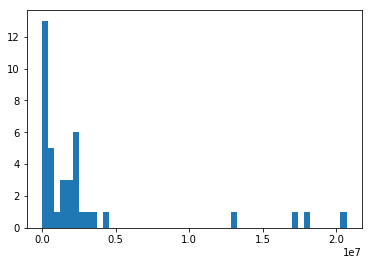

In [649]:
plt.figure(4)
plt.hist(np.abs(lasso_regr_BO),bins=50)
plt.show()

## Nominations as target

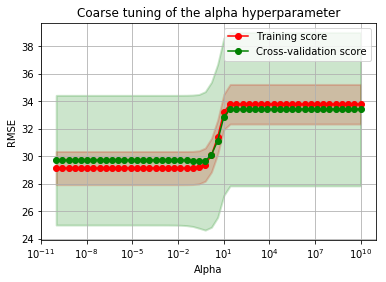

In [650]:
alpha_range = np.logspace(-10, 10, 50)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['Nominations'],
                                                       param_name="lasso__alpha",param_range=alpha_range,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range,
                      'log', 'Coarse tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

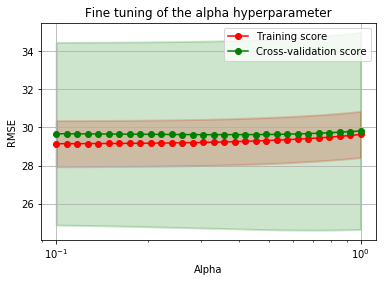

In [651]:
alpha_range_fine = np.logspace(-1, 0, 30) 

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['Nominations'],
                                                       param_name="lasso__alpha",param_range=alpha_range_fine,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range_fine,
                      'log', 'Fine tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

In [652]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
lasso_pipeline.set_params(lasso__alpha = optimal_alpha_l)

lasso_pipeline.fit(X_train,y_train['Nominations'])
lasso_predict = lasso_pipeline.predict(X_test)

lasso_regr_Nom = np.abs(lasso_pipeline.named_steps['lasso'].coef_.copy())
print(lasso_regr_Nom)

[7.61238856 0.30796315 3.64252322 4.08059791 1.52122079 1.69453147
 0.         4.07548877 1.90768377 2.32098908 1.59887546 2.55663272
 1.10572779 0.21322434 4.55116493 0.         0.         0.
 0.49423601 0.10453546 1.11498269 0.22995361 0.         1.0624696
 1.23709432 1.58365646 2.67093858 1.2498362  1.01149266 1.79436191
 0.20293021 1.20969334 0.         0.         0.87897376 0.37797816
 0.         3.33520597 0.26452209]


In [702]:
feature_zero_Nom = X_train.columns[np.where(lasso_regr_Nom == 0)[0]]
set_non_zero_features_Nom = set(X_train.columns[np.where(lasso_regr_Nom != 0)[0]])

# The feature list is ordeed by importance then we keep only the 10 most important features
feature_Nom = X_train.columns[np.argsort(lasso_regr_Nom)][::-1][:10]

In [726]:
feature_Nom

Index(['Runtime', 'drama', 'BoxOffice_directors', 'action', 'BoxOffice_actors',
       'r', 'thriller', 'comedy', 'animation', 'adventure'],
      dtype='object')

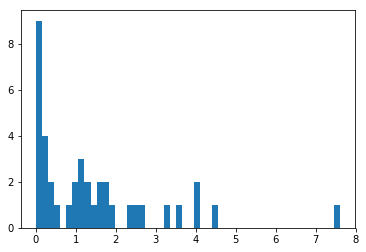

In [699]:
plt.hist(np.abs(lasso_regr_Nom),bins=50)
plt.show()

## Wins as target

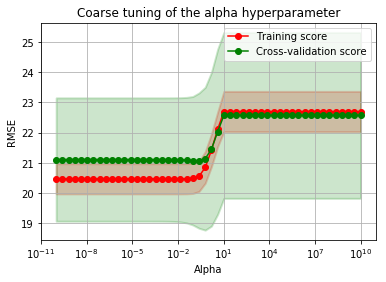

In [719]:
alpha_range = np.logspace(-10, 10, 50)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['Wins'],
                                                       param_name="lasso__alpha",param_range=alpha_range,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range,
                      'log', 'Coarse tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

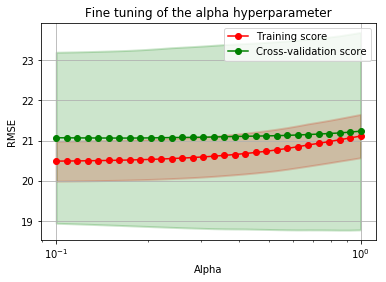

In [720]:
alpha_range_fine = np.logspace(-1, 0, 30) 

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['Wins'],
                                                       param_name="lasso__alpha",param_range=alpha_range_fine,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range_fine,
                      'log', 'Fine tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

In [721]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
lasso_pipeline.set_params(lasso__alpha = optimal_alpha_l)

lasso_pipeline.fit(X_train,y_train['Wins'])
lasso_predict = lasso_pipeline.predict(X_test)

lasso_regr_Wins = np.abs(lasso_pipeline.named_steps['lasso'].coef_.copy())
print(lasso_regr_Wins)

[4.78246424e+00 2.22445562e+00 1.51394301e+00 2.49023984e+00
 7.18047008e-01 1.50971320e+00 1.06568634e-03 2.29039018e+00
 6.81754764e-01 1.83167396e+00 4.65385550e-01 2.02763470e+00
 1.27330715e+00 0.00000000e+00 2.16425951e+00 0.00000000e+00
 3.18399587e-01 1.92925381e-01 7.61355427e-01 2.63487427e-01
 4.15027190e-01 7.99990630e-01 0.00000000e+00 9.44553514e-01
 3.71789649e-01 1.01169187e+00 1.14975372e+00 7.31435633e-01
 5.69576727e-01 2.83913096e+00 3.00789621e-01 1.52706844e+00
 1.13448342e+00 0.00000000e+00 4.89178848e-01 3.36955088e-01
 0.00000000e+00 1.49375374e+00 4.80217985e-01]


In [722]:
feature_zero_Wins = X_train.columns[np.where(lasso_regr_Wins == 0)[0]]
set_non_zero_features_Wins = set(X_train.columns[np.where(lasso_regr_Wins != 0)[0]])

# The feature list is ordeed by importance then we keep only the 10 most important features
feature_Wins = X_train.columns[np.argsort(lasso_regr_Wins)][::-1][:10]

In [723]:
feature_Wins

Index(['Runtime', 'english', 'BoxOffice_directors', 'action', 'Budget',
       'drama', 'comedy', 'animation', 'other', 'BoxOffice_actors'],
      dtype='object')

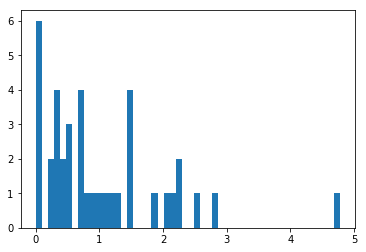

In [724]:
plt.hist(np.abs(lasso_regr_Wins),bins=50)
plt.show()

## Importance of features

In [706]:
# The list of features important to determine all the different target
set(feature_MC) & set(feature_RT)&set(feature_Nom) & set(feature_Wins)&set(feature_BO)&set(feature_IMdB)

{'BoxOffice_actors',
 'BoxOffice_directors',
 'Runtime',
 'animation',
 'drama',
 'r'}

In [707]:
# Extreme list of "important" features
set_non_zero_features_BO&set_non_zero_features_IMdB&set_non_zero_features_MC&\
set_non_zero_features_RT&set_non_zero_features_Nom

{'BoxOffice_actors',
 'BoxOffice_directors',
 'BoxOffice_writers',
 'Budget',
 'Runtime',
 'action',
 'animation',
 'comedy',
 'documentary',
 'drama',
 'english',
 'foreign',
 'horror',
 'music',
 'musical',
 'r',
 'sport',
 'thriller',
 'war',
 'western'}

In [714]:
# List of "important" features for the imdb grades target
feature_IMdB

Index(['Runtime', 'drama', 'animation', 'Budget', 'comedy',
       'BoxOffice_directors', 'BoxOffice_actors', 'r', 'horror',
       'documentary'],
      dtype='object')

In [713]:
# Conservative list of "important" features for the critics target
feature_MC & feature_RT

Index(['drama', 'Runtime', 'Budget', 'documentary', 'animation', 'r',
       'BoxOffice_writers', 'BoxOffice_directors', 'BoxOffice_actors', 'usa'],
      dtype='object')

In [712]:
feature_BO

Index(['Runtime', 'Budget', 'BoxOffice_actors', 'BoxOffice_directors',
       'BoxOffice_writers', 'usa', 'animation', 'crime', 'drama', 'western',
       'english', 'spanish', 'pg', 'r'],
      dtype='object')

In [727]:
# Conservative list of "important" features for the academic target
feature_Nom & feature_Wins

Index(['Runtime', 'drama', 'BoxOffice_directors', 'action', 'BoxOffice_actors',
       'comedy', 'animation'],
      dtype='object')

In [725]:
feature_Nom | feature_Wins

Index(['BoxOffice_actors', 'BoxOffice_directors', 'Budget', 'Runtime',
       'action', 'adventure', 'animation', 'comedy', 'drama', 'english',
       'other', 'r', 'thriller'],
      dtype='object')

# 4. Graph creation

After data cleaning, we proceed to the creation of the graph by computing its adjacency matrix. We wish to create an adjacency matrix containing all features. We will hence compute several adjacency matrices that we will then add (using weighting factors). Such matrices are:

- Crew (actors, writers and directors): how many crew members the movies have in common
- Budget: the similarity between movies will be based on how close the budgets are (in a log scale)
- Genre: how many genres two movies have in common
- Production: is it the same production company?
- Plot: how many common words two films have in common
- Language: since the only two categories are English and Foreign, a score between 0 and 2 between 2 movies
- Country: how many countries in common 
- Runtime: the similarity between movies will be based on how close the runtimes are (in a log scale)
- Rated category: binary score = same category or different
- Release: the dissimilarity is how far apart the two movies are in time

In [211]:
final_df = pd.read_pickle("final_df.pkl")
final_df.head()

,Actors,BoxOffice,Country,Director,Genre,Language,Plot,Production,Rated,Released,...,imdbGrade,tomatoGrade,metacriticGrade,Wins,Nominations,Budget,Awards,BoxOffice_actors,BoxOffice_directors,BoxOffice_writers
0,"{Stephen Lang, Sam Worthington, Sigourney Weav...",749700000,"{Foreign, USA}",{James Cameron},"{Adventure, Fantasy, Sci-Fi, Action}","{Spanish, English}","{home, following, paraplegic, missioncomesrntw...",{20th Century Fox},{PG-13},2009-12-18,...,78,82,83,88,128,237000000,0,8749225092,947816802,1173684544
1,"{Keira Knightley, Geoffrey Rush, Orlando Bloom...",309404152,{USA},{Gore Verbinski},"{Adventure, Fantasy, Action}",{English},"{Sparrownd, Barbossa, find, last, treacheryndt...",{Buena Vista},{PG-13},2007-05-25,...,71,44,50,20,46,300000000,0,11629554832,1329316576,6439780219
2,"{Christoph Waltz, Ralph Fiennes, Daniel Craig,...",208777731,"{Foreign, USA}",{Sam Mendes},"{Adventure, Action, Thriller}","{English, Spanish, Other}","{007, events, missions, organization, sends, c...",{Sony},{PG-13},2015-11-06,...,68,64,60,8,32,245000000,0,6479178314,706988158,4338225868
3,"{Joseph Gordon-Levitt, Christian Bale, Gary Ol...",448130642,"{Foreign, USA}",{Christopher Nolan},"{Action, Thriller}","{Foreign, English}","{Joker, terrorist, Gotham, City, Eight, exile,...",{Warner Bros},{PG-13},2012-07-20,...,84,87,78,38,103,250000000,0,10153049812,1781097215,6820715653
4,"{Samantha Morton, Willem Dafoe, Taylor Kitsch,...",73058679,{USA},{Andrew Stanton},"{Adventure, Sci-Fi, Action}",{English},"{vet, princess, War, creatures, barbarians, Tr...",{Disney},{PG-13},2012-03-09,...,66,51,51,2,8,260000000,0,2742531870,677337921,2082778011


## A. Crew adjacency

In [ ]:
weights_crew = np.zeros((len(final_df), len(final_df)))
weights_dir = np.zeros((len(final_df), len(final_df)))
weights_actors = np.zeros((len(final_df), len(final_df)))
weights_writer = np.zeros((len(final_df), len(final_df)))

In [ ]:
for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_dir[i][j] = weights_dir[i][j] + len(final_df['Director'][i] & final_df['Director'][j])
weights_dir = weights_dir + weights_dir.T

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_actors[i][j] = weights_actors[i][j] + len(final_df['Actors'][i] & final_df['Actors'][j])
weights_actors = weights_actors + weights_actors.T

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_writer[i][j] = weights_writer[i][j] + len(final_df['Writer'][i] & final_df['Writer'][j])
weights_writer = weights_writer + weights_writer.T

In [ ]:
# Add and save
weights_crew = weights_dir + weights_actors + weights_writer

np.save('weights_dir.npy', weights_dir)
np.save('weights_act.npy', weights_actors)
np.save('weights_wri.npy', weights_writer)
np.save('weights_crew.npy', weights_crew)

## B. Budget adjacency
### TODO: check the computing method

Two similar films are two films that have a similar budget. This is why we cannot use the absolute difference between the films as a similarity metric. 

Moreover, two films having a budget of millions but being 1 million dollars appart are more similar than a film having a budget of 10 dollars and a film having a budget of 1 million and 10 dollars. This is why before computing the absolute difference in budget, we must convert the budget to a logarithmic scale. 

Then, once the differences have been computed, the weight matrix has to be:
$ weights = max(weights) - weights$

In [ ]:
weights_budget = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_budget[i][j] = np.abs(np.log10(final_df['Budget'][i]) -  np.log10(final_df['Budget'][j]))

# Symmetrize
weights_budget = weights_budget + weights_budget.T
weights_budget = np.max(weights_budget) - weights_budget

# Save 
np.save('weights_budget.npy', weights_budget)

## C. Genre adjacency

In [ ]:
weights_genre = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_genre[i][j] = len(final_df['Genre'][i] & final_df['Genre'][j])

# Symmetrize
weights_genre = weights_genre + weights_genre.T

# Save 
np.save('weights_genre.npy', weights_genre)

## D. Production 

In [ ]:
weights_prod = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_prod[i][j] = len(final_df['Production'][i] & final_df['Production'][j])

# Symmetrize
weights_prod = weights_prod + weights_prod.T

# Save 
np.save('weights_prod.npy', weights_prod)

## E. Plot

In [ ]:
weights_plot = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_plot[i][j] = len(final_df['Plot'][i] & final_df['Plot'][j])

# Symmetrize
weights_plot = weights_plot + weights_plot.T

# Save 
np.save('weights_plot.npy', weights_plot)

## F. Country, Language

In [ ]:
weights_lang = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_lang[i][j] = len(final_df['Language'][i] & final_df['Language'][j])

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_lang[i][j] = weights_lang[i][j] + len(final_df['Country'][i] & final_df['Country'][j])

# Symmetrize        
weights_lang = weights_lang + weights_lang.T

# Save
np.save('weights_lang.npy', weights_lang)

## G. Release date
### TODO: check computing method

In [ ]:
weights_date = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        if (not pd.isnull(final_df['Released'][i])) and (not pd.isnull(final_df['Released'][j])):
            weights_date[i][j] = abs(final_df['Released'][i] - final_df['Released'][j]).days
        else:
            weights_date[i][j] = 37742

# Symmetrize        
weights_date = weights_date + weights_date.T

# Save
np.save('weights_date.npy', weights_date)

## H. Runtime
### TODO: check computing method

In [ ]:
weights_runtime = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_runtime[i][j] = np.abs(final_df['Runtime'][i] -  final_df['Runtime'][j])

# Symmetrize
weights_runtime = weights_runtime + weights_runtime.T
weights_runtime = np.max(weights_runtime) - weights_runtime

# Save 
np.save('weights_runtime.npy', weights_runtime)

## I. Rated category

In [ ]:
weights_rated = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_rated[i][j] = len(final_df['Rated'][i] & final_df['Rated'][j])

# Symmetrize
weights_rated = weights_rated + weights_rated.T

# Save 
np.save('weights_rated.npy', weights_rated)

In [ ]:
weights_crew = np.load('weights_crew.npy')
weights_budget = np.load('weights_budget.npy')
weights_genre = np.load('weights_genre.npy')
weights_prod = np.load('weights_prod.npy')
weights_plot = np.load('weights_plot.npy')
weights_lang = np.load('weights_lang.npy')
weights_date = np.load('weights_date.npy')
weights_runtime = np.load('weights_runtime.npy')
weights_rated = np.load('weights_rated.npy')

## Total adjacency matrix

Now, we need to add all weight matrices. It is however of use to add them using weigh factors, as some features may be more important than others.

In [ ]:
crew_factor = 1
budget_factor = 1
genre_factor = 1
prod_factor = 1
plot_factor = 1
lang_factor = 1
date_factor = 1
runtime_factor = 1
rated_factor = 1
sum_factors = (crew_factor + budget_factor + genre_factor + prod_factor + 
               plot_factor + lang_factor + date_factor + runtime_factor + rated_factor)

weights = (crew_factor*weights_crew + budget_factor*weights_budget + genre_factor*weights_genre + 
           prod_factor*weights_prod + plot_factor*weights_plot + lang_factor*weights_lang + 
           date_factor*weights_date + runtime_factor*weights_runtime + rated_factor*weights_rated) / sum_factors

# The adjacency matrix is the normalized weight matrix
adjacency = weights / np.max(weights)

# Save
np.save('weights.npy', weights)
np.save('adjacency.npy', adjacency)

In [ ]:
weights = np.load('weights.npy')
adjacency = np.load('adjacency.npy')